In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sys

In [2]:
def getFirstEqGroupPackForMili(outputDictionary):
    packOfSet = dict()
    
    existsCombinations = set()
    combinationsDictionary = dict()
    nextPackName = 1
    
    for i in outputDictionary:
        if not outputDictionary[i] in existsCombinations:
            existsCombinations.add(outputDictionary[i])
            combinationsDictionary[outputDictionary[i]] = nextPackName
            packOfSet[nextPackName] = [int(i)]
            nextPackName = nextPackName + 1
        else:
            packOfSet[combinationsDictionary[outputDictionary[i]]].append(int(i))
    
    return packOfSet

In [3]:
def getNewTable(movementTable, eqGroupPack):
    newTable = movementTable.copy()

    for i, j in movementTable.iteritems():
        for k, l in j.items():
            for m, n in eqGroupPack.items():
                if movementTable.loc[k][i] in n:
                    newTable.loc[k][i] = m
                    
    return newTable

In [4]:
def getEqGroupPack(table, oldEqGroupPack):
    packOfSet = dict()
    nextPackName = 1
    
    for i in oldEqGroupPack.items():
        for j in i[1::2]:
            existsCombinations = set()
            combinationsDictionary = dict()
            for k in j:
                newCombo = ""
                for l, m in table.iterrows():
                    newCombo = newCombo + str(m[k-1])
                if not newCombo in existsCombinations:
                    existsCombinations.add(newCombo)
                    combinationsDictionary[newCombo] = nextPackName
                    packOfSet[nextPackName] = [k]
                    nextPackName = nextPackName + 1
                else:
                    packOfSet[combinationsDictionary[newCombo]].append(k)
        
    return packOfSet

In [5]:
#Просмотр входных данных на правильность
dataMovements = pd.read_csv("MurAutomatMovements.csv", sep=',', header=1, index_col=0, encoding='cp1251', skipinitialspace=True, dtype=int)
dataOutputDictionary = dict()
with open('MurAutomatMovements.csv', 'r') as f:
    outputs = f.readline().replace(" ", "").replace("\n", "").split(",")
    ways = f.readline().replace(" ", "").replace("\n", "").split(",")
    for i in range(0, len(ways)):
        dataOutputDictionary[ways[i]] = outputs[i]
        
print("Данные движений автомата")
print(dataMovements)
print("Данные выходов автомата")
print(dataOutputDictionary)

Данные движений автомата
   1  2  3  4  5  6
1  3  4  3  4  5  6
2  5  6  5  6  1  2
Данные выходов автомата
{'1': '1', '2': '1', '3': '2', '4': '2', '5': '1', '6': '1'}


In [6]:
eqGroups = getFirstEqGroupPackForMili(dataOutputDictionary)
print(eqGroups)
newTable = getNewTable(dataMovements, eqGroups)
print(newTable)
oldTable = dataMovements

while not oldTable.equals(newTable) and len(eqGroups) < newTable.shape[1]:
    eqGroups = getEqGroupPack(newTable, eqGroups)
    oldTable = newTable.copy()
    newTable = getNewTable(dataMovements, eqGroups)
    print(eqGroups)
    print()
    print(newTable)
    print()

print("Последняя группа эквивалентности, после расщепления")
print(eqGroups)

{1: [1, 2, 5, 6], 2: [3, 4]}
   1  2  3  4  5  6
1  2  2  2  2  1  1
2  1  1  1  1  1  1
{1: [1, 2], 2: [5, 6], 3: [3, 4]}

   1  2  3  4  5  6
1  3  3  3  3  2  2
2  2  2  2  2  1  1

{1: [1, 2], 2: [5, 6], 3: [3, 4]}

   1  2  3  4  5  6
1  3  3  3  3  2  2
2  2  2  2  2  1  1

Последняя группа эквивалентности, после расщепления
{1: [1, 2], 2: [5, 6], 3: [3, 4]}


In [7]:
minimizedTableMovements = newTable.copy()
minimizedOutputDictionary = dataOutputDictionary.copy()
columnsToDel = []
for i in eqGroups:
    for j in eqGroups[i]:
        if j != eqGroups[i][0]:
            columnsToDel.append(j-1)

minimizedTableMovements = minimizedTableMovements[[str(eqGroups[i][0]) for i in eqGroups]]
for i in columnsToDel:
    minimizedOutputDictionary.pop(str(i))

In [8]:
minimizedTableMovements.columns = [i for i in eqGroups]

print("Движения минимизированного автомата")
print(" ", [int(j) for i, j in minimizedOutputDictionary.items()])
print(minimizedTableMovements)
print()

Движения минимизированного автомата
  [1, 2, 1]
   1  2  3
1  3  2  3
2  2  1  2



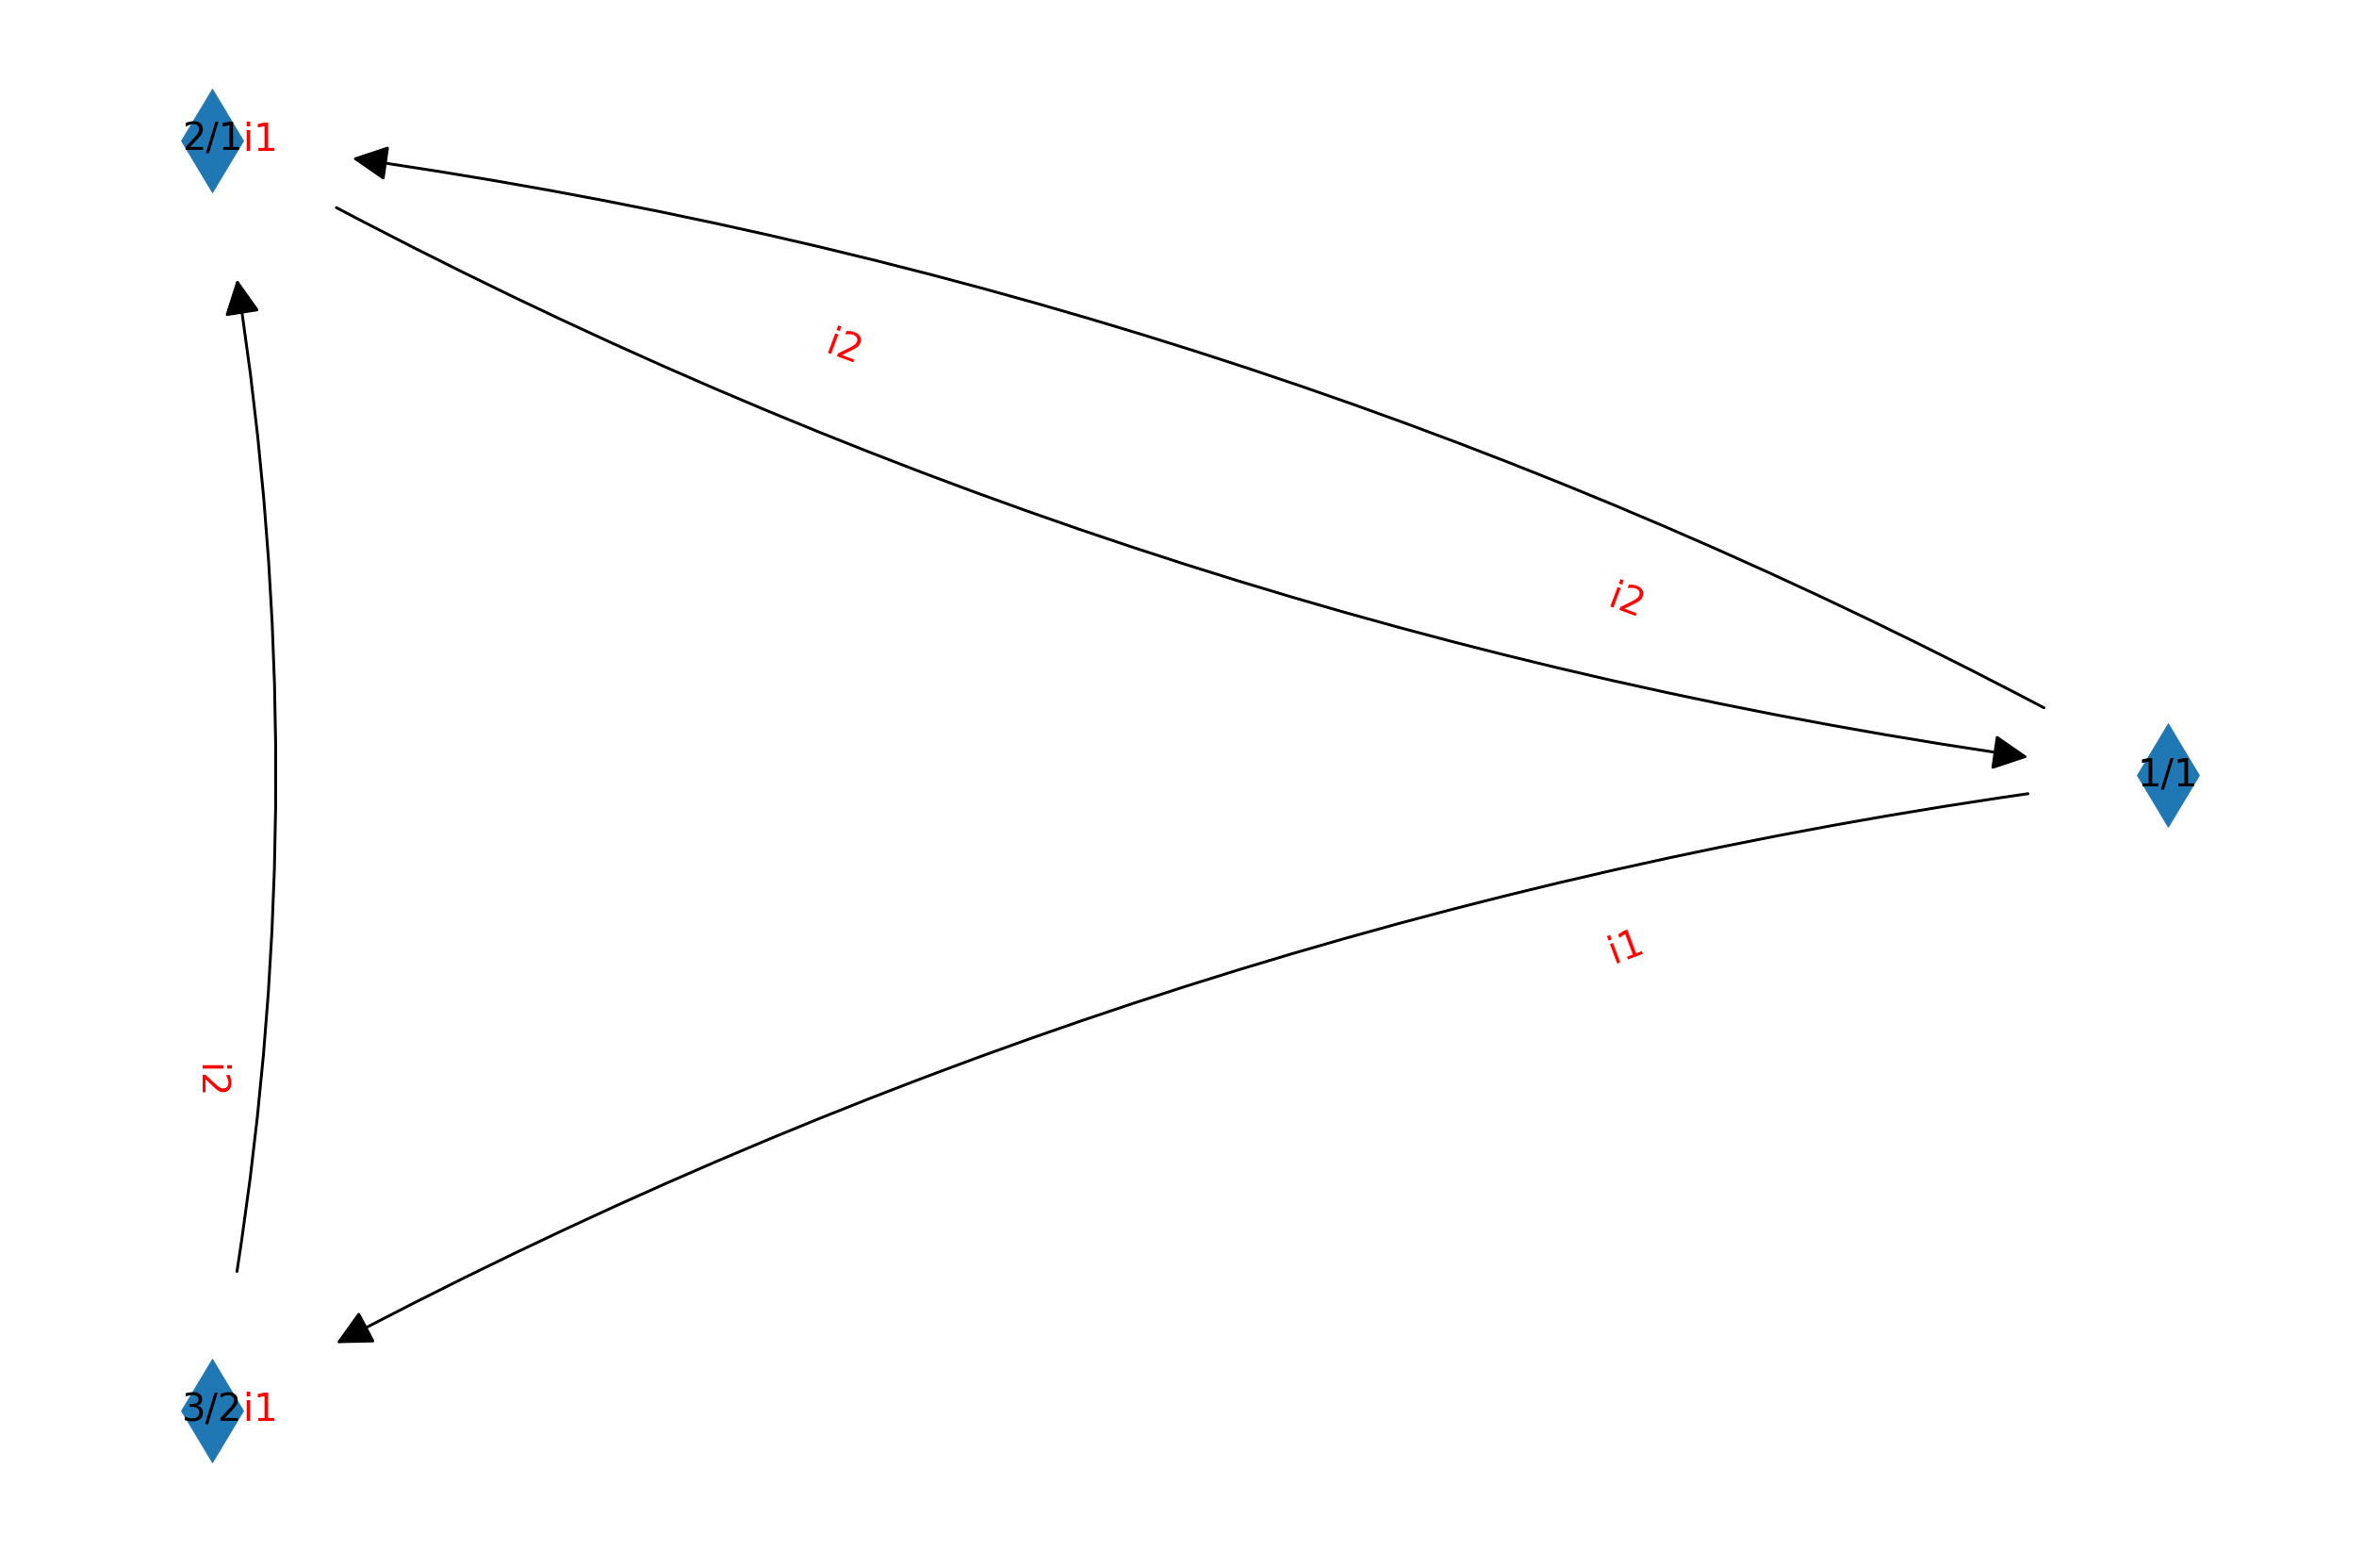

In [9]:
#Строим граф
plt.figure(figsize=(45, 30))
G = nx.DiGraph()

for i, j in minimizedTableMovements.iteritems():
    name = str(i) + "/" + dataOutputDictionary[str(i)]
    G.add_node(name)

pos = nx.circular_layout(G)
    
for i, j in minimizedTableMovements.iteritems():
    for k, l in j.items():
        G.add_edge(str(i) + "/" + dataOutputDictionary[str(i)], str(l) + "/" + dataOutputDictionary[str(l)])
        nx.draw_networkx_edge_labels(G, pos, label_pos=0.7, edge_labels = {(str(i) + "/" + dataOutputDictionary[str(i)], str(l) + "/" + dataOutputDictionary[str(l)]): "        i" + str(k)}, font_color='red', font_size=40, verticalalignment="center")
        
nx.draw_networkx_nodes(G, pos, node_size=6000, node_shape="d")
## edges
nx.draw_networkx_edges(G, pos, width=3, arrowsize=80, min_source_margin=150, min_target_margin=150, connectionstyle="arc3, rad=0.1")

nx.draw_networkx_labels(G, pos, font_size=40, font_family='sans-serif')
plt.axis('off')

plt.show()